# Concurrent optimization of orientation and topology

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from scipy.optimize import bisect

torch.set_default_dtype(torch.double)


from torchfem import Planar

## Parameters

In [122]:
# Orthotropic material parameters
E_1 = 100000
E_2 = 10000
nu_12 = 0.3
G_12 = 5000

# Mesh parameters
Nx = 60
Ny = 30

# Optimization parameters (SIMP penalization, volume fraction, move limit, step size)
p = 3
volfrac = 0.4
move = 0.1
ori_step = 1000.0

# Volume constraint
V_0 = volfrac * Nx * Ny

## Material model 

The material is a linear, elastic, homogeneous and orthotropic material. If we assume a plane stress state, we may write the relation between stress and strain (material model) in terms of the compliance tensor 
$$
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
=
\begin{pmatrix}
    \frac{1}{E_{xx}} & -\frac{\nu_{xy}}{E_{xx}} & 0\\
    -\frac{\nu_{yx}}{E_{yy}} & \frac{1}{E_{yy}} & 0\\
    0 & 0 & \frac{1}{G_{xy}}
\end{pmatrix}
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
$$
or as stiffness tensor 
$$
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
=
\underbrace{\begin{pmatrix}
    \frac{E_{xx}}{1-\nu_{xy}\nu_{yx}} & \frac{\nu_{xy}E_{yy}}{1-\nu_{xy}\nu_{yx}} & 0\\
    \frac{\nu_{yx}E_{xx}}{1-\nu_{xy}\nu_{yx}}& \frac{E_{yy}}{1-\nu_{xy}\nu_{yx}} & 0\\
    0 & 0 & G_{xy}
\end{pmatrix}}_{\bm{C}}
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
$$

The stiffness is characterized by four properties $E_{xx}, E_{yy}, G_{xy}, \nu_{xy}$. The tensor is symmetric with 
$$ \frac{\nu_{xy}}{E_{xx}}=\frac{\nu_{yx}}{E_{yy}} $$

Fortunately, we have a 'torchfem' function that computes the stiffness tensor from the four properties.

In [123]:
from torchfem.materials import OrthotropicPlaneStress


mat = OrthotropicPlaneStress(E_1=E_1, E_2=E_2, nu_12=nu_12, G_12=G_12)

## Rotation of the material 

The matrix entries in stress and strain tensors may vary if we rotate the frame of reference. We can use the rotation matrix 
$$
\bm{R} (\phi)
=
\begin{pmatrix}
    \cos^2{\phi} & \sin^2{\phi} & 2\sin{\phi}\cos{\phi}\\
    \sin^2{\phi} & \cos^2{\phi} & -2\sin{\phi}\cos{\phi}\\
    -\sin{\phi}\cos{\phi} & \sin{\phi}\cos{\phi} & \cos^2{\phi}-\sin^2{\phi}
\end{pmatrix}
$$

to perform an in-plane rotation by $\phi$ by computing 

$$
\begin{pmatrix}
    \sigma_{xx}'\\
    \sigma_{yy}'\\
    \sigma_{xy}'
\end{pmatrix}
= 
\bm{R} (\phi)
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
$$

Note that this matrix is not symmetrical due to the convention of writing $\gamma_{xy}=2\varepsilon_{xy}$ for the shear stress. This is rooted in the definition of the shear modulus $\sigma_{xy}=G\gamma_{xy}$. 

We can use the rotation matrix to compute the rotated stiffness tensor $\bm{C}_{rot}$ according to 
$$\bm{C}_{rot} = \bm{R}(\phi) \bm{C} \bm{R}^\top(\phi).$$

In [124]:
# Rotation tensor
def R(phi):
    cos = torch.cos(phi)
    cos2 = cos**2
    sin = torch.sin(phi)
    sin2 = sin**2
    sincos = sin * cos
    return torch.stack(
        [
            torch.stack([cos2, sin2, 2 * sincos]),
            torch.stack([sin2, cos2, -2 * sincos]),
            torch.stack([-sincos, sincos, cos2 - sin2]),
        ],
    )

## Mesh generation

We create a simple domain of $N_x$ by $N_y$ elements. The domain is a rectangle and we apply a singular force at the tip, while the left side is fully clamped.

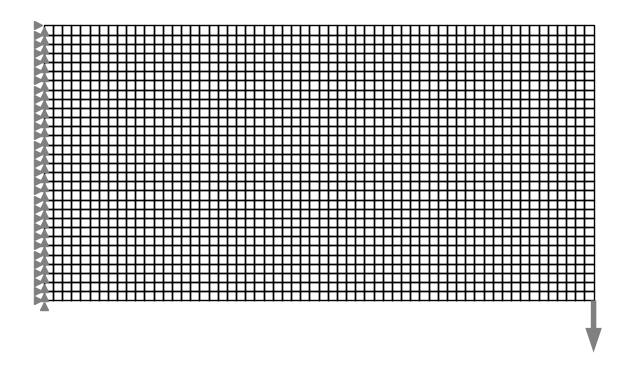

In [125]:
# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(0.0, Ny, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for i in range(Nx):
    for j in range(Ny):
        n0 = j + i * (Ny + 1)
        elements.append([n0, n0 + Ny + 1, n0 + Ny + 2, n0 + 1])

# Load at top
forces = torch.zeros_like(nodes)
forces[(Nx + 1) * (Ny + 1) - Ny - 1, 1] = -1

# Constrained displacement at left end
constraints = torch.zeros_like(nodes, dtype=bool)
displacements = torch.zeros_like(nodes)
constraints[nodes[:, 0] == 0, :] = True

# Thickness
thickness = torch.ones(len(elements))

# Create and plot the domain
beam = Planar(nodes, elements, forces, displacements, constraints, thickness, mat.C())
beam.plot()

## Objective function

The objective function is the compliance of the structure. The compliance is defined as
$$
C = \frac{1}{2}\bm{u}^\top \bm{f}
$$
where $\bm{u}$ is the global displacement vector and $\bm{f}$ is the global force vector. 

The compliance is a measure of the energy stored in the structure due to the applied force and we want to minimize w.r.t. to the relative element densities $\bm{\rho}$ and the element-wise fiber orientations $\bm{\phi}$ in order to get a stiff structure.

In [126]:
def compliance(rho, phi):
    beam.C = torch.einsum("..., ij...,jk,lk...->...il", rho**p, R(phi), mat.C(), R(phi))
    u, f = beam.solve()
    return 0.5 * torch.inner(u.ravel(), f.ravel())

## Filter

We employ a sensitivity filter for the relative densities to regularize the problem (mesh dependency) and to avoid checkerboard patterns. The filter is defined as
$$
\widetilde{\frac{\partial C}{\partial \rho_j}} = \frac{1}{\rho_j} \frac{\sum_i H_{ji} \rho_i \frac{\partial C}{\partial \rho_i} }{\sum_i H_{ji}}
$$
where $H_{ji}$ is the filter kernel. We use a simple linear filter kernel defined as 
$$
H_{ji} = \max(0, r - \lVert \bm{x}_i - \bm{x}_j \rVert)
$$
with element centers $\bm{x}_i$ and $\bm{x}_j$ and filter radius $r$.

In [127]:
filter_radius = 1.5
ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
dist = torch.cdist(ecenters, ecenters)
H = filter_radius - dist
H[dist > filter_radius] = 0.0

## The optimizer

In [128]:
def optimize(rho, phi, n_iter=100):
    # Bounds
    rho_min = 0.001 * torch.ones_like(rho)
    rho_max = torch.ones_like(rho)

    # Storage for compliance
    energies = []

    for _ in tqdm(range(n_iter)):
        C = compliance(rho, phi)
        dC_dphi = torch.autograd.grad(C, phi, retain_graph=True)[0]
        dC_drho = torch.autograd.grad(C, rho)[0]
        dC_drho = H @ (rho * dC_drho) / H.sum(dim=0) / rho

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -dC_drho / mu
            upper = torch.min(rho_max, (1 + move) * rho)
            lower = torch.max(rho_min, (1 - move) * rho)
            rho_trial = G_k**0.5 * rho
            return torch.max(torch.min(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return rho_k.sum() - V_0

        # Find the root of g(mu)
        with torch.no_grad():
            mu = bisect(g, 1e-10, 100.0)

        # Advance rho and phi
        rho.data = make_step(mu)
        phi.data -= ori_step * dC_dphi.data

        # Track compliance
        with torch.no_grad():
            energies.append(C.item())
    return energies

In [129]:
@torch.no_grad()
def plot_solution(rho, phi, ptype="element", color="lightskyblue"):
    # Compute properties
    centers = beam.nodes[beam.elements, :].mean(dim=1)
    dir = torch.stack([torch.cos(phi), -torch.sin(phi), torch.zeros_like(phi)]).T

    # Plot orientations
    beam.plot(element_property=rho, linewidth=0.2, cmap="gray_r")
    if ptype == "element":
        plt.quiver(
            centers[:, 0],
            centers[:, 1],
            dir[:, 0],
            dir[:, 1],
            pivot="middle",
            headlength=0,
            headaxislength=0,
            headwidth=0,
            width=0.003,
            color=color,
            alpha=rho,
        )
    if ptype == "stream":
        dir[rho < 0.75] = 0.0
        plt.streamplot(
            centers[:, 0].reshape(Nx, Ny).numpy()[:, 0],
            centers[:, 1].reshape(Nx, Ny).numpy()[0, :],
            dir[:, 0].reshape(Nx, Ny).T.numpy(),
            dir[:, 1].reshape(Nx, Ny).T.numpy(),
            color=color,
            broken_streamlines=False,
            arrowstyle="-",
            cmap="coolwarm",
        )
    plt.show()

## Optimize with fibers initially aligned in x 

In [130]:
# Design variables
phi = 0.0 * torch.ones((len(beam.elements)), requires_grad=True)
rho = volfrac * torch.ones((len(beam.elements)), requires_grad=True)

100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


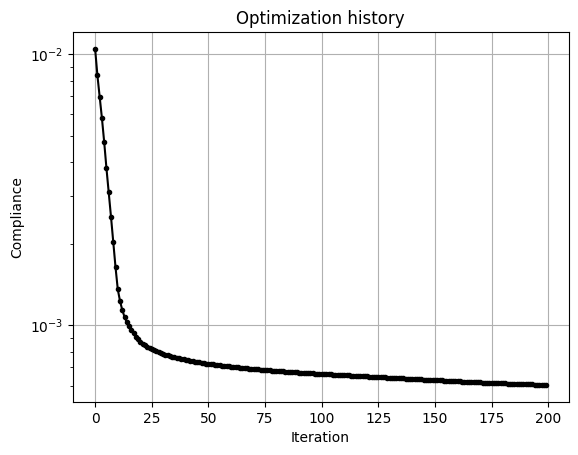

In [131]:
energies = optimize(rho, phi, 200)
plt.semilogy(energies, ".-k")
plt.grid()
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

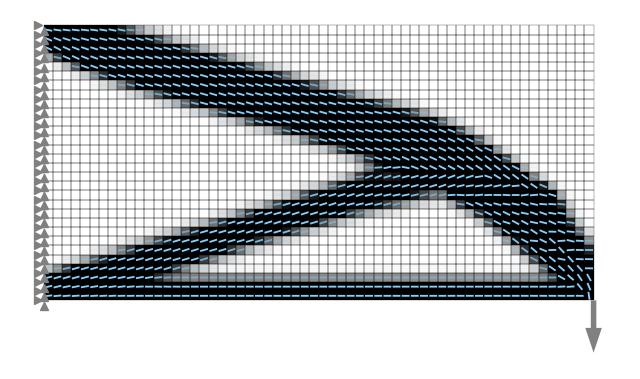

In [132]:
plot_solution(rho, phi)

## Generate fiber paths with streamlines

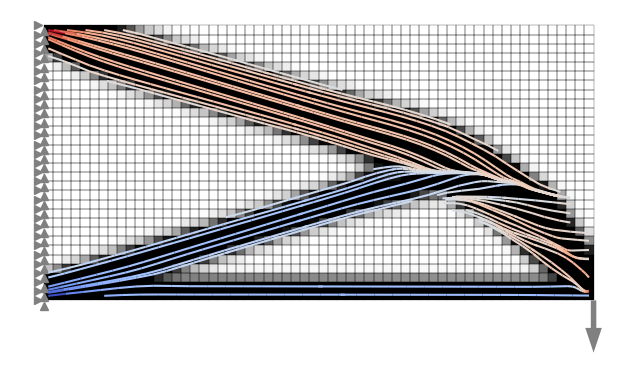

In [133]:
u, f = beam.solve()
stress = beam.compute_stress(u)
e = torch.stack(
    [torch.linalg.eigvalsh(torch.tensor([[s[0], s[2]], [s[2], s[1]]])) for s in stress]
)
mag, pos = torch.max(torch.abs(e), dim=1)
pval = torch.tensor([ev[p] for ev, p in zip(e, pos)])
pval = pval.reshape(Nx, Ny).T.numpy()
plot_solution(rho, phi, ptype="stream", color=pval)